In [2]:
import pandas as pd
import numpy as np
import ast
import csv
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_auc_score, roc_curve, accuracy_score, precision_score,
    recall_score, f1_score
)
from esda.moran import Moran
from libpysal.weights import lat2W

sns.set_theme()

In [3]:
self_att_df = pd.read_csv(f'results/self_att_200_df.csv')
self_att_df = self_att_df[:200]
self_att_df = self_att_df.drop_duplicates(['data_id', 'proof'])
self_att_df['data_id'] = \
    self_att_df['data_id'].astype(str) + \
    self_att_df['proof'].astype(str)

mtd0_df = pd.read_csv(f'results/mtd0_200_df.csv')
mtd0_df = mtd0_df[:200]
mtd0_df = mtd0_df.drop_duplicates(['data_id', 'proof'])
mtd0_df['data_id'] = \
    mtd0_df['data_id'].astype(str) + \
    mtd0_df['proof'].astype(str)

## Choosing the best head

In [4]:
n_layers = 30
n_heads = 32
l_q = []
for i in range(n_layers):
  for j in range(n_heads):
    l_q.append(f'{i} {j}')

In [5]:
def check_is_random(data):
    w = lat2W(*data.shape)  # соседство на сетке
    moran = Moran(data.flatten(), w)

    print(f"Moran's I: {moran.I}, p-value: {moran.p_sim}")
    if moran.I > 0 and moran.p_sim < 0.05:
        print('Значения неслучайны')
    else:
        print('Значения случайны')

In [6]:
def choose_best_head(df, name, k=1000):
    true_means = df[df["is_correct"]][l_q].mean()
    false_means = df[~df["is_correct"]][l_q].mean()

    means_diff = np.abs(true_means - false_means)
    means_diff = means_diff.apply(pd.to_numeric, errors='coerce')
    reshaped_means = means_diff.values.reshape(n_layers, n_heads)
    check_is_random(reshaped_means)

    heatmap_data = k * reshaped_means
    annot_data = heatmap_data.astype(int)

    plt.figure(figsize=(10, 8))
    sns.heatmap(
        heatmap_data, 
        annot=annot_data, 
        fmt="d",
        cmap='viridis', 
        xticklabels=np.arange(1, n_heads + 1), 
        yticklabels=np.arange(1, n_layers + 1),
        annot_kws={"size": 8}
    )
    plt.title(f'Heatmap of absolute difference of the {name} (values ×{k})')
    plt.xlabel('Query head')
    plt.ylabel('Layer')

    plt.savefig(f'plots/heatmaps/{name}.png', dpi=300)
    plt.show()

Moran's I: 0.049212139095582974, p-value: 0.012
Значения неслучайны


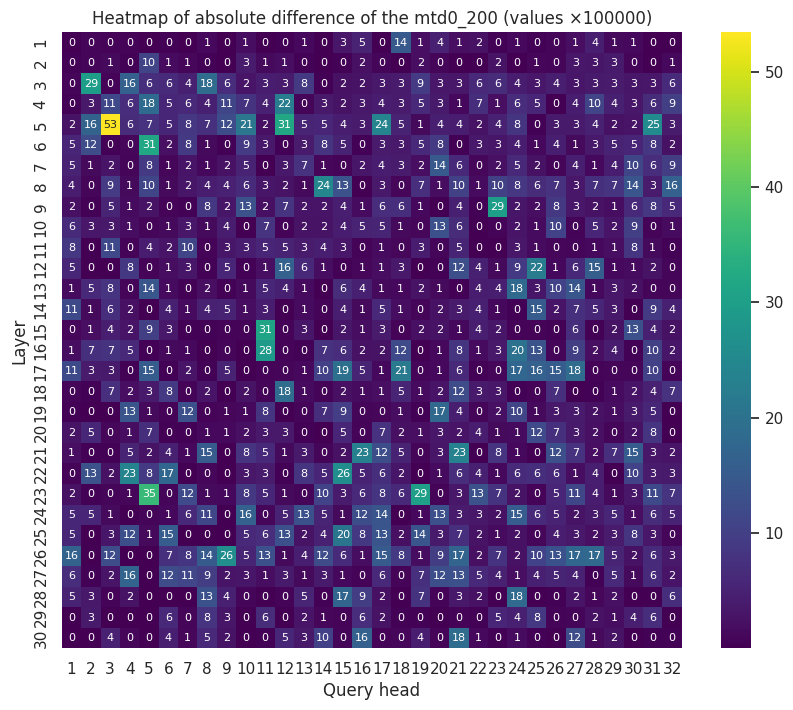

Moran's I: 0.053449637083385994, p-value: 0.02
Значения неслучайны


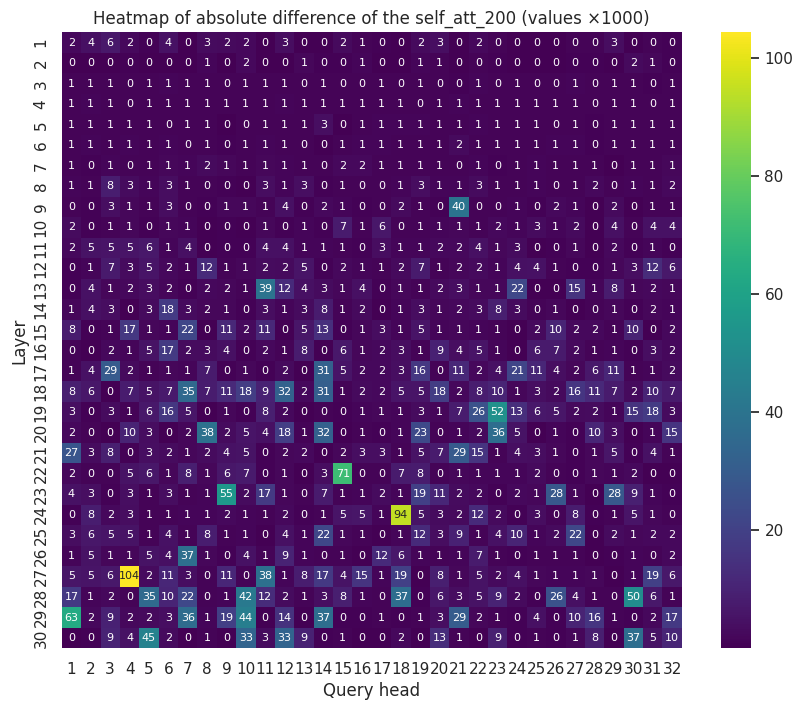

In [7]:
choose_best_head(mtd0_df, "mtd0_200", k=100000)
choose_best_head(self_att_df, "self_att_200")

In [8]:
def show_head_distribution(df, layer, head, name):
    true_df = df[df['is_correct']][f'{layer} {head}']
    false_df = df[~df['is_correct']][f'{layer} {head}']
    plt.figure(figsize=(10, 6))

    # Построение гистограмм
    sns.histplot(true_df, bins=20, alpha=0.5, label="Успешные", color="blue", stat="proportion")
    sns.histplot(false_df, bins=20, alpha=0.5, label="Неуспешные", color="red", stat="proportion")

    # Добавление подписей
    plt.xlabel(name)
    plt.ylabel("Доля")
    plt.title("Распределение значений для успешных и неуспшных доказательств для лучшей головы")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.7)

    plt.savefig(f'plots/distributions/{name}.png', dpi=300)
    # Отображение графика
    plt.show()

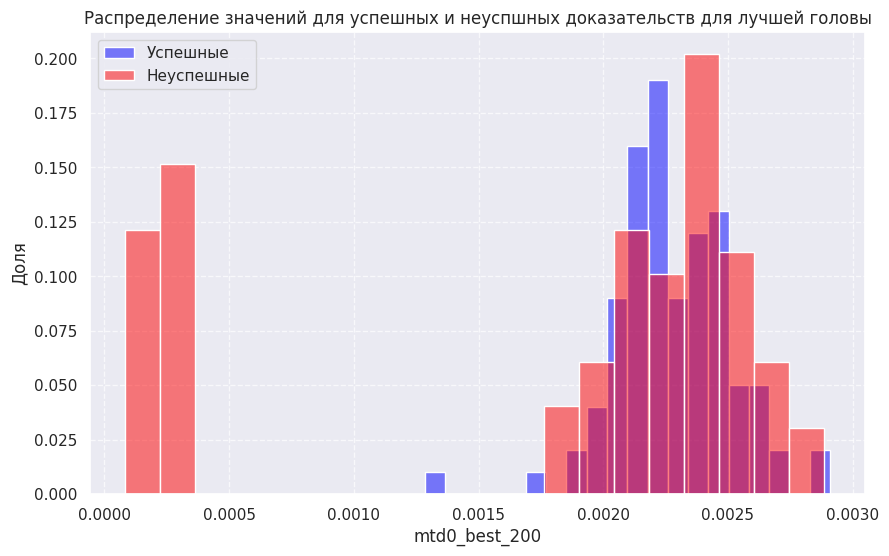

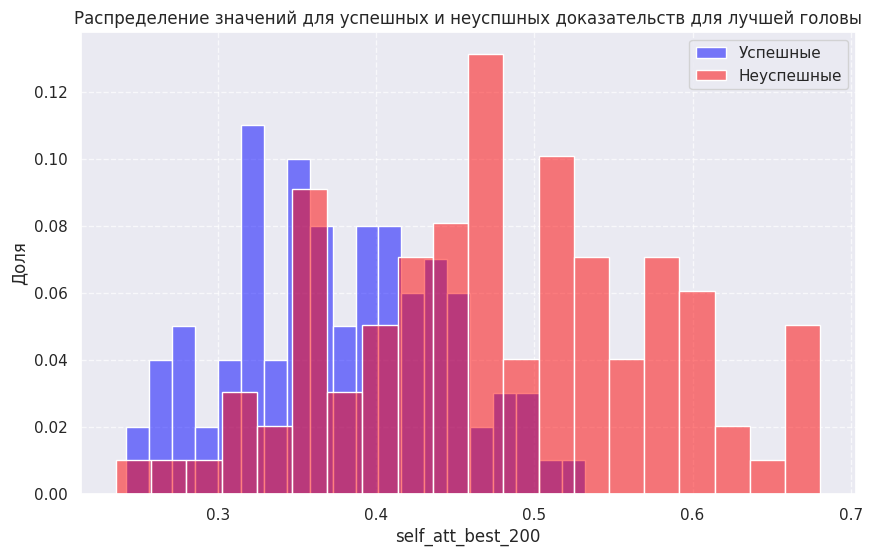

In [9]:
mtd0_best_layer = 4
mtd0_best_head = 2
show_head_distribution(
    mtd0_df, 
    mtd0_best_layer, 
    mtd0_best_head, 
    "mtd0_best_200"
)

self_att_best_layer = 26
self_att_best_head = 3
show_head_distribution(
    self_att_df,
    self_att_best_layer,
    self_att_best_head,
    "self_att_best_200"
)

In [10]:
def show_ROC_curve(df, layer, head, name, k):
    y_true = df["is_correct"].astype(int)
    y_score = k * df[f"{layer} {head}"]

    fpr, tpr, _ = roc_curve(y_true, y_score)
    auc_score = roc_auc_score(y_true, y_score)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"AUC = {auc_score:.3f}", color="blue")
    # Линия случайного угадывания
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")

    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.title(f"ROC-кривая для лучшей головы {name}")
    plt.legend()
    plt.grid(True)
    plt.savefig(f"plots/ROC_curves/{name}.png")

    plt.show()


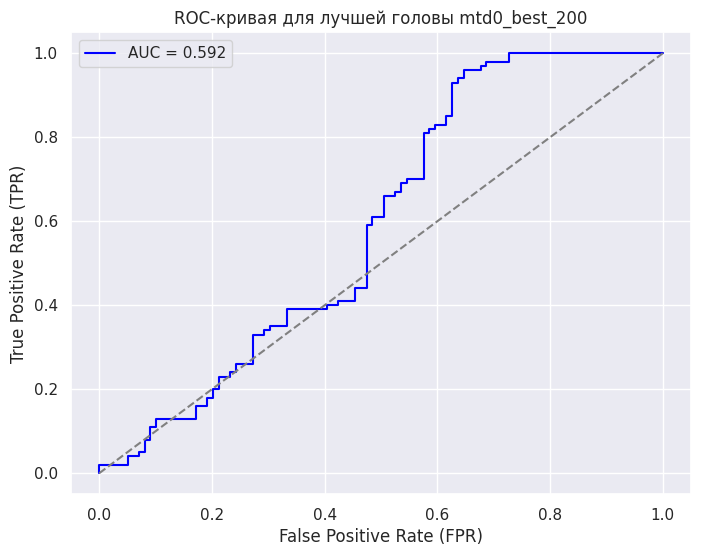

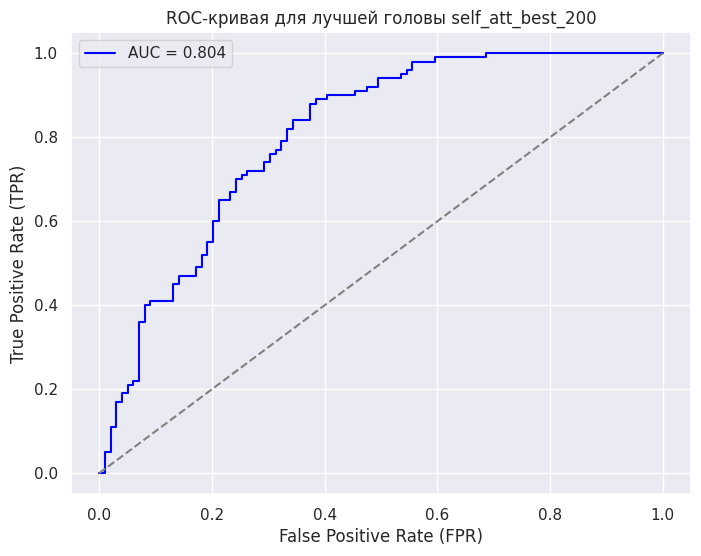

In [11]:
show_ROC_curve(
    mtd0_df, 
    mtd0_best_layer, 
    mtd0_best_head, 
    "mtd0_best_200",
    k = 1
)

show_ROC_curve(
    self_att_df,
    self_att_best_layer,
    self_att_best_head,
    "self_att_best_200",
    k = -1
)

### Теперь сравним все три подхода

In [12]:
mtd0_best_l_q = f'{mtd0_best_layer} {mtd0_best_head}'
mtd0_best_df = mtd0_df[['data_id', mtd0_best_l_q]]
mtd0_best_df = mtd0_best_df.rename(
    columns={mtd0_best_l_q : 'mtd0_score'}
)

self_att_best_l_q = f'{self_att_best_layer} {self_att_best_head}'
self_att_best_df = self_att_df[['data_id', self_att_best_l_q]]
self_att_best_df = self_att_best_df.rename(
    columns={self_att_best_l_q : 'self_att_score'}
)
self_att_best_df['self_att_score'] = 1 - self_att_best_df['self_att_score']

In [13]:
self_consistency_df = pd.read_csv('results/self_consistency_200_df.csv')
self_consistency_df = self_consistency_df.drop_duplicates(['data_id', 'proof'])
self_consistency_df['data_id'] = \
    self_consistency_df['data_id'].astype(str) + \
    self_consistency_df['proof'].astype(str)

In [14]:
df = mtd0_best_df.merge(self_att_best_df, on='data_id')
df = df.merge(self_consistency_df[['data_id', 'answer', 'is_correct']], on='data_id')

In [15]:
len(df)

199

In [16]:
def get_metrics(y_true, y_scores, name="model"):
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    j_scores = tpr - fpr
    best_idx = np.argmax(j_scores)
    best_threshold = thresholds[best_idx]
    y_pred = (y_scores >= best_threshold).astype(int)

    return {
        "name": name,
        "threshold": round(float(best_threshold), 4),
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "f1": f1_score(y_true, y_pred, zero_division=0),
        "auc": roc_auc_score(y_true, y_scores),
    }

In [17]:
def get_metrics_binary(y_true, y_pred_binary, name="model"):
    y_pred = np.array(y_pred_binary).astype(int)
    return {
        "name": name,
        "threshold": "N/A",
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "f1": f1_score(y_true, y_pred, zero_division=0),
        "auc": roc_auc_score(y_true, y_pred)
    }

In [18]:
def evaluate_all_classifiers(df: pd.DataFrame) -> pd.DataFrame:
    y_true = df["is_correct"].astype(int)

    metrics_1 = get_metrics(y_true, df["mtd0_score"], name="mtd0")
    metrics_2 = get_metrics(y_true, df["self_att_score"], name="self_att")

    y_llm_raw = df["answer"].copy()
    # для 200 нанов вообще нет
    nan_mask = y_llm_raw.isna()
    y_llm_raw[nan_mask] = np.random.randint(0, 2, size=nan_mask.sum())
    y_llm = y_llm_raw.astype(int)

    metrics_llm = get_metrics_binary(y_true, y_llm, name="LLM (answer)")

    return pd.DataFrame([metrics_1, metrics_2, metrics_llm])

In [19]:
evaluate_all_classifiers(df)

,name,threshold,accuracy,precision,recall,f1,auc
0,mtd0,0.002,0.658291,0.600000,0.96,0.738462,0.591616
1,self_att,0.5516,0.753769,0.704000,0.88,0.782222,0.804343
2,LLM (answer),N/A,0.512563,0.588235,0.10,0.170940,0.514646


In [20]:
df['answer'].describe()

count       197
unique        2
top       False
freq        182
Name: answer, dtype: object